<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


CHAFAI Tinhinane &
SADYKOVA Karima

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

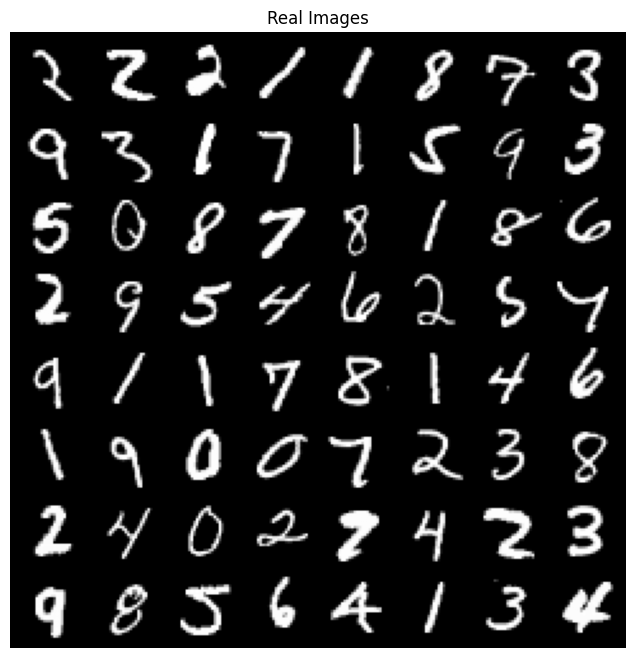

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

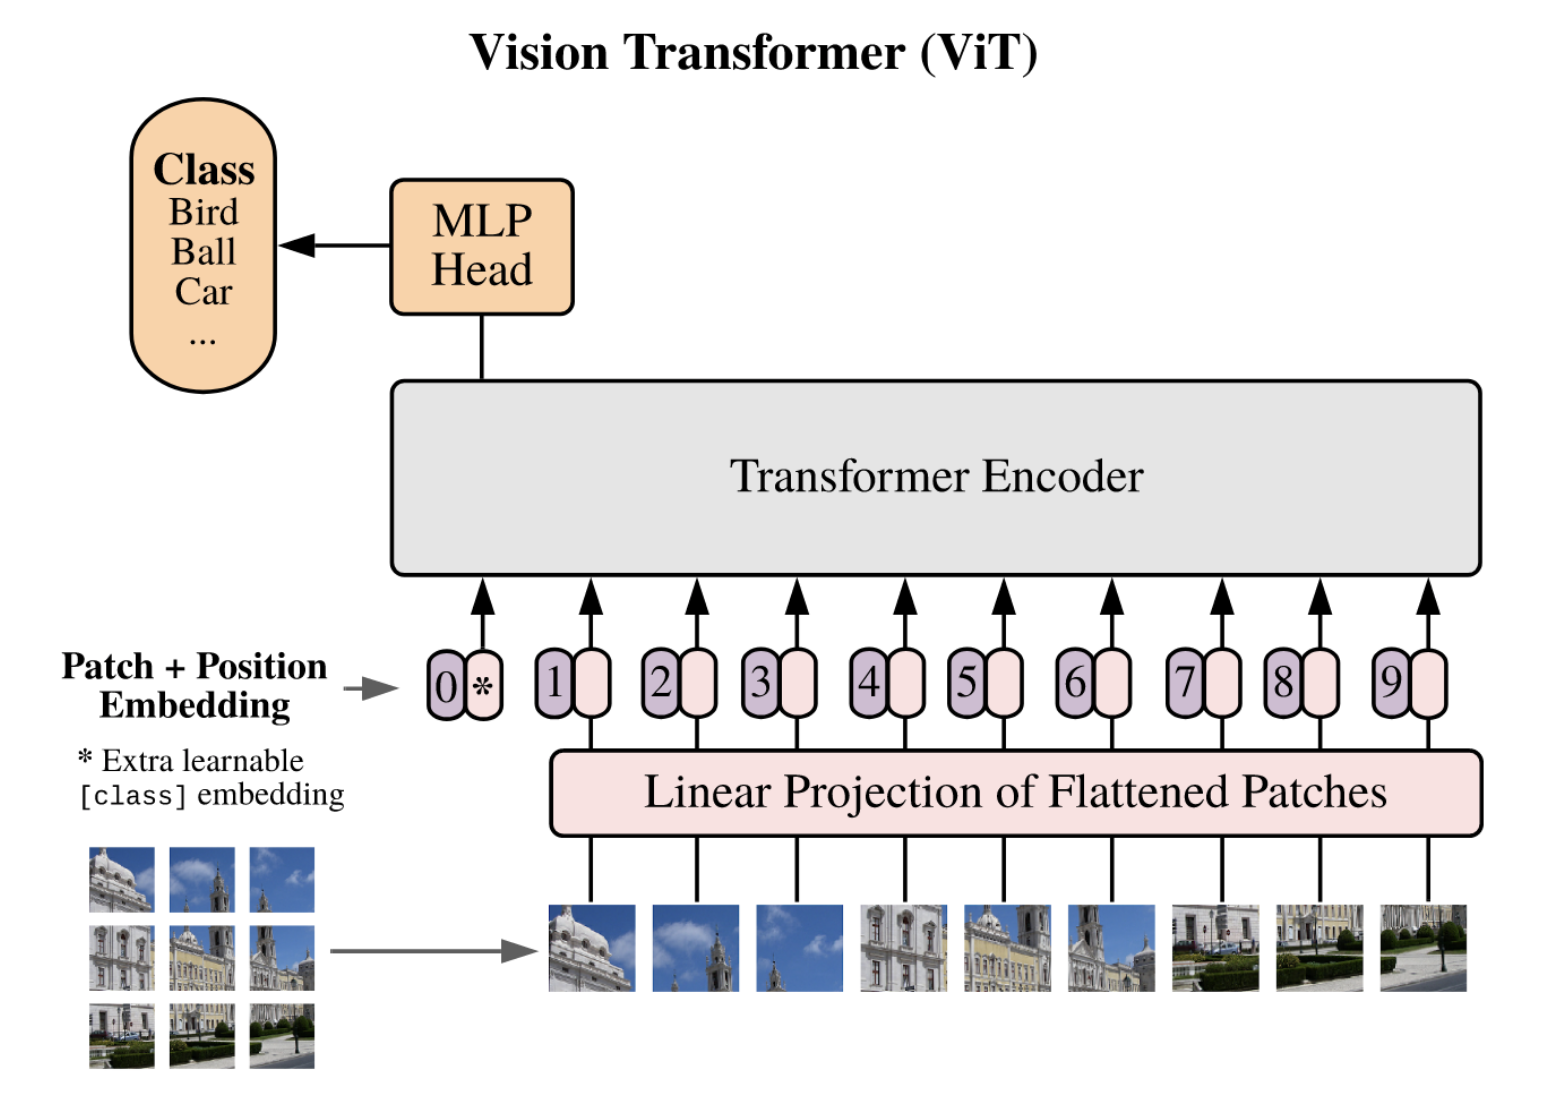

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    ## TODO
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.projection(x)

    # B : Batch size
    # C : Number of Channels
    # H : Height
    # W : Width
    B, C, H, W = x.shape
    ## TODO
    # Reshape the tensor to get a final tensor of shape (batch_size, nb_tokens, embedding_dim)
    # We reshape this tensor using the view method to get a final shape of (batch_size, num_patches^2, embedding_dim)
    # We use permute to change the order of dimensions to (batch_size, nb_tokens, embedding_dim), where nb_tokens corresponds to the number of patches in the image.
    x = x.view(B, C, -1).permute(0, 2, 1)

    # x.shape() -> B, N, C
    # N : Number of tokens/patches
    return x


In [ ]:
random_tensor = torch.randn(1, 3, 224, 224)  # Input image tensor
patch_embed_layer = PatchEmbed(in_chan=3, patch_size=16, embed_dim=768)
output = patch_embed_layer(random_tensor)

print(output.shape)  # This should print the shape (batch_size, nb_tokens, embedding_dim)

torch.Size([1, 196, 768])


# Transformer encoder

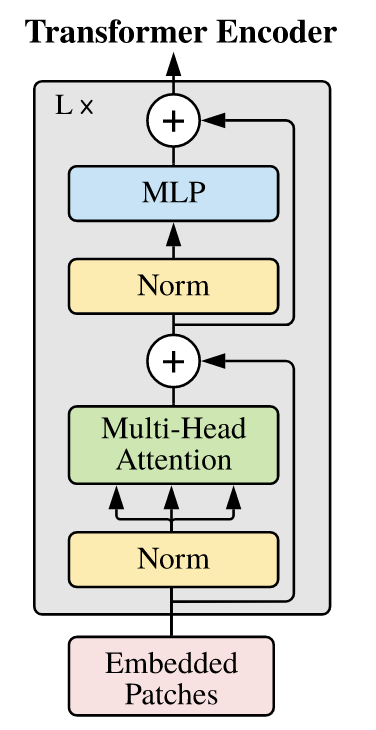

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hid_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hid_features)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hid_features, in_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x


MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!




In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()

    # TODO
    self.W_q = nn.Linear(embed_dim, embed_dim)
    self.W_k = nn.Linear(embed_dim, embed_dim)
    self.W_v = nn.Linear(embed_dim, embed_dim)
    self.scale = 1.0 / (embed_dim ** 0.5)
    self.final_projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    # TODO: compute the Q, K, V
    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)

    # TODO: compute the attention matrix using Q and K
    attention = torch.matmul(q, k.transpose(1, 2)) * self.scale
    attention = torch.nn.functional.softmax(attention, dim=-1)

    # TODO: compute the final version using the attention,
    # V, and the final projection
    x = torch.matmul(attention, v)
    x = self.final_projection(x)

    return x


SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

In [ ]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    head_dim = embed_dim // num_heads
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads

    self.q = nn.Linear(embed_dim, embed_dim)
    self.k = nn.Linear(embed_dim, embed_dim)
    self.v = nn.Linear(embed_dim, embed_dim)
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape
    # print(B, N, C)

    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.
    q = q.view(B, N, self.num_heads, -1).permute(0, 2, 1, 3)
    k = k.view(B, N, self.num_heads, -1).permute(0, 2, 1, 3)
    v = v.view(B, N, self.num_heads, -1).permute(0, 2, 1, 3)

    # Try to write at each operation the shape of the tensor if you
    # feel confused.

    # TODO
    attention = torch.matmul(q, k.permute(0, 1, 3, 2)) * self.scale
    # Apply attention to values and concatenate
    x = torch.matmul(torch.nn.functional.softmax(attention, dim=-1), v)
    x = x.permute(0, 2, 1, 3).contiguous().view(B, N, C)

    x = self.projection(x)

    return x

x = torch.randn(32, 16, 6)
MultiHeadsSelfAttention(6, 2)(x).shape

torch.Size([32, 16, 6])

In [ ]:
multi_head_attention = MultiHeadsSelfAttention(6, 2)
x = torch.randn(32, 16, 6)  # Input tensor with shape (batch_size, sequence_length, input_features)
output = multi_head_attention(x)

print(output.shape)  # This should print the shape (32, 16, 6)

torch.Size([32, 16, 6])


# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

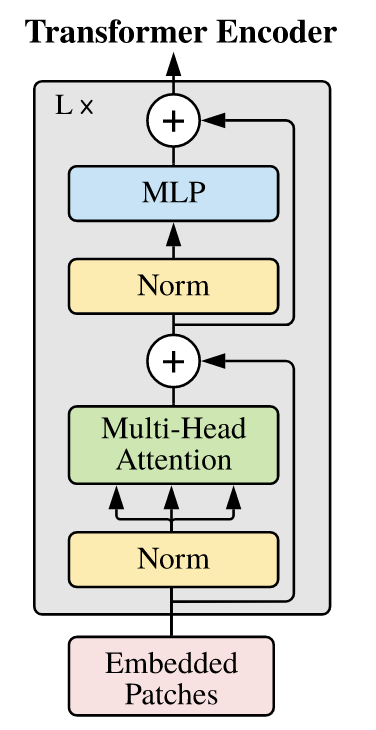

In [ ]:
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()

    # TODO
    self.norm1 = nn.LayerNorm(embed_dim)
    self.self_attention = MultiHeadsSelfAttention(embed_dim, num_heads)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, int(embed_dim * mlp_ratio))


  def forward(self, x):
    # TODO
    # Layer normalization after embedded patches
    x = self.norm1(x)

    # Multi-Head Self-Attention
    att = self.self_attention(x)

    # Residual connection and layer normalization
    x = x + att
    x = self.norm2(x)

    # MLP (Feed-Forward Network)
    mlp_out = self.mlp(x)

    # Residual connection
    x = x + mlp_out

    return x

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it? \\
- Explain whay is the the positional embedding (PE) and why it is important? \\

For PE, you can use a sinusoidal encoding (see below), or fully learned.


### Sinusoidal PE


In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.rand(1, 1, embed_dim)) # nn.Parameter to be trained and optimise its value
    self.pos_embed = nn.Parameter(get_positional_embeddings(num_patches + 1, embed_dim)) # +1 for class token
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, nb_classes)

  def forward(self, x):
    # print(x.size())
    x = self.patch_embed(x) ## image to patches
    # print("image to patches : ", x.size())

    ## concatenating class token
    x = torch.cat((self.class_token.expand(x.size(0), -1, -1), x), dim=1)
    # print("concat class token : ", x.size())
    ## adding positional embedding (information about patches order)
    x = x + self.pos_embed
    # print("add pos embed : ", x.size())

    ## forward in the transformer
    x = self.blocks(x)
    # print("transf : ", x.size())

    ## Normalize the output
    x = self.norm(x)
    # print("norm : ", x.size())

    output = self.head(x[:, 0])  # Class Token output ## classification output

    return output


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

In [ ]:
# Example usage with input size 128, 3 blocks, and 7x7 patches
vit_model = ViT(128, 3, 7)
input_tensor = torch.randn(32, 1, 28, 28)  # Input tensor with shape (batch_size, channels, height, width)
output = vit_model(input_tensor)

print(output.shape)  # This should print the shape (32, nb_classes)

torch.Size([32, 10])


# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [ ]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

--- Epoch 0 ---
Train loss: 0.0016018787337447708
--- Epoch 1 ---
Train loss: 0.00039268779810175663
--- Epoch 2 ---
Train loss: 0.0002977765881367482
--- Epoch 3 ---
Train loss: 0.00024020323514656265
--- Epoch 4 ---
Train loss: 0.00020494842060226769
--- Epoch 5 ---
Train loss: 0.00018111014659104478
--- Epoch 6 ---
Train loss: 0.00016579733048817166
--- Epoch 7 ---
Train loss: 0.00014848495148462286
--- Epoch 8 ---
Train loss: 0.00013824346108978698
--- Epoch 9 ---
Train loss: 0.00012103442236076646
Test accuracy: 97.52


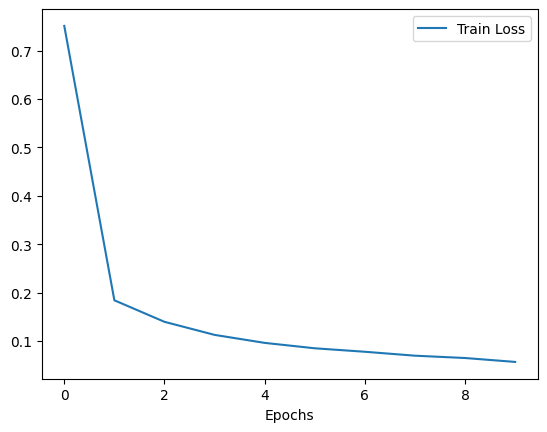

In [ ]:
import matplotlib.pyplot as plt

epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters())

train_losses = []  # To store train losses

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()
  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")


acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")
# Plotting train and test accuracy
plt.figure()
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

epochs = 10

# Define a function to train and evaluate the model with different hyperparameters
def train_and_evaluate(embed_dim, patch_size, nb_blocks):
    model = ViT(embed_dim, nb_blocks, patch_size).cuda()
    opt = torch.optim.Adam(model.parameters())

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        train_loss = 0.0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            opt.zero_grad()
            yhat = model(x)
            loss = F.cross_entropy(yhat, y)
            loss.backward()

            opt.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        acc = eval_model(model, test_loader)
        test_accuracies.append(acc)

    return train_losses, test_accuracies

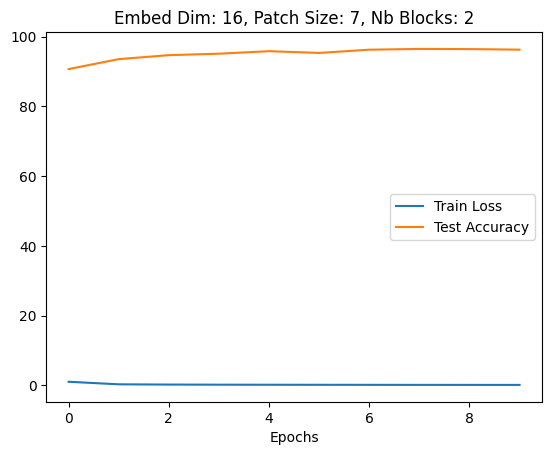

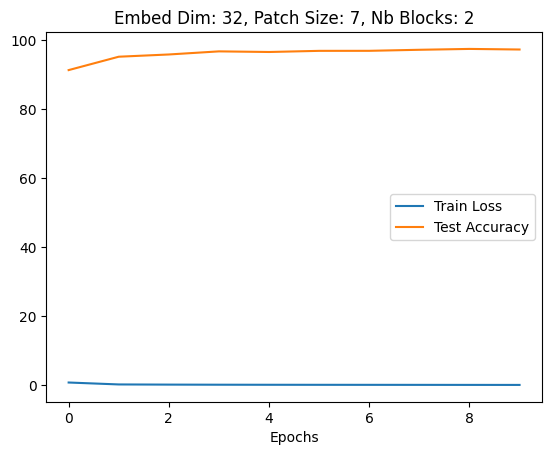

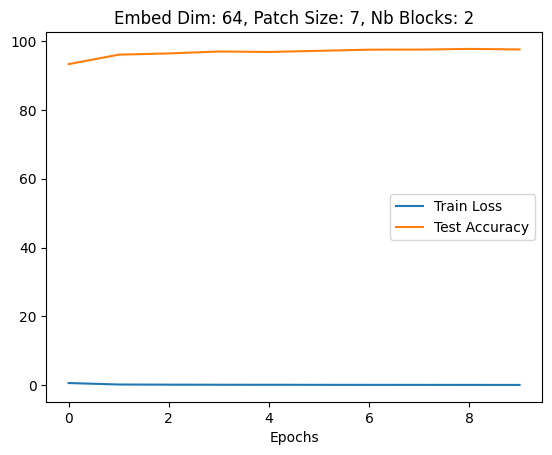

In [ ]:
# Define a range of hyperparameter values to test
embed_dim_values = [16, 32, 64]
patch_size_values = [7, 14, 28]
nb_blocks_values = [1, 2, 4]

# Store results in a dictionary
results = {}

# embed_dim = 32
patch_size = 7
nb_blocks = 2
for embed_dim in embed_dim_values:
    # for patch_size in patch_size_values:
    #     for nb_blocks in nb_blocks_values:
            key = (embed_dim, patch_size, nb_blocks)
            train_losses, test_accuracies = train_and_evaluate(embed_dim, patch_size, nb_blocks)
            results[key] = (train_losses, test_accuracies)

# Plot and analyze the results
for key, (train_losses, test_accuracies) in results.items():
    embed_dim, patch_size, nb_blocks = key
    plt.figure()
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.title(f'Embed Dim: {embed_dim}, Patch Size: {patch_size}, Nb Blocks: {nb_blocks}')
    plt.legend()
    plt.show()

# Analyze the final performance and discuss improvements
# You can analyze test accuracies, compare different hyperparameters, and suggest improvements in this section.

In [ ]:
# embed_dim = 16 accuracy, patch = 7, nb_blocks = 2
print(results[(16, 7, 2)][1][-1])

# embed_dim = 32 accuracy, patch = 7, nb_blocks = 2
print(results[(32, 7, 2)][1][-1])

# embed_dim = 64 accuracy, patch = 7, nb_blocks = 2
print(results[(64, 7, 2)][1][-1])

96.28
97.33
97.6


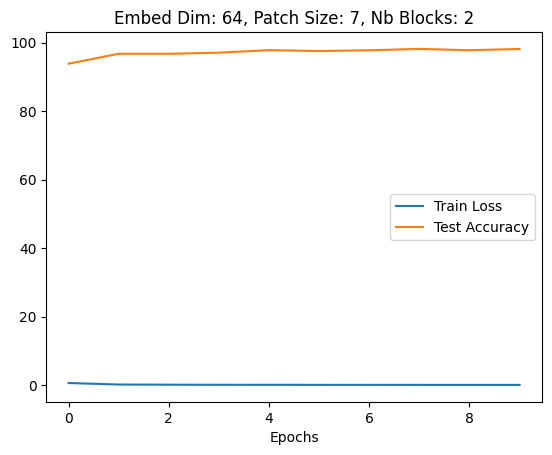

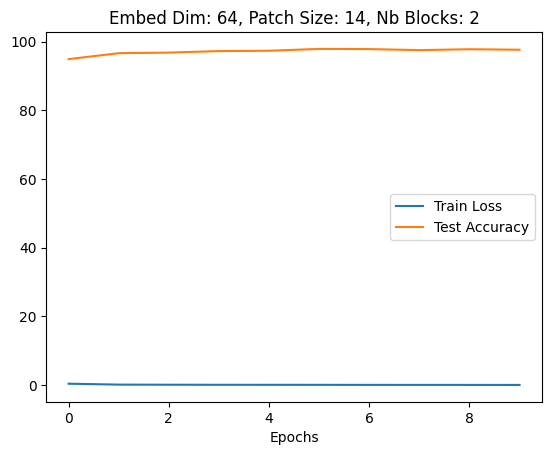

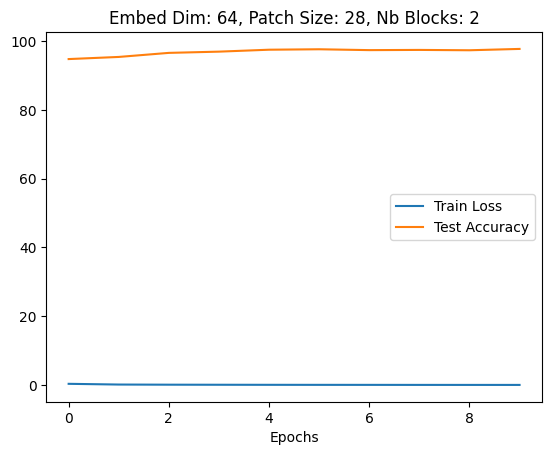

In [ ]:
# Define a range of hyperparameter values to test
# embed_dim_values = [16, 32, 64]
patch_size_values = [7, 14, 28]
# nb_blocks_values = [1, 2, 4]

# Store results in a dictionary
results = {}

embed_dim = 64
# patch_size = 7
# nb_blocks = 2
for patch_size in patch_size_values:
        key = (embed_dim, patch_size, nb_blocks)
        train_losses, test_accuracies = train_and_evaluate(embed_dim, patch_size, nb_blocks)
        results[key] = (train_losses, test_accuracies)

# Plot and analyze the results
for key, (train_losses, test_accuracies) in results.items():
    embed_dim, patch_size, nb_blocks = key
    plt.figure()
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.title(f'Embed Dim: {embed_dim}, Patch Size: {patch_size}, Nb Blocks: {nb_blocks}')
    plt.legend()
    plt.show()

In [ ]:
# embed_dim = 64 accuracy, patch = 7, nb_blocks = 2
print(results[(64, 7, 2)][1][-1])

# embed_dim = 64 accuracy, patch = 14, nb_blocks = 2
print(results[(64, 14, 2)][1][-1])

# embed_dim = 64 accuracy, patch = 28, nb_blocks = 2
print(results[(64, 28, 2)][1][-1])

98.18
97.61
97.69


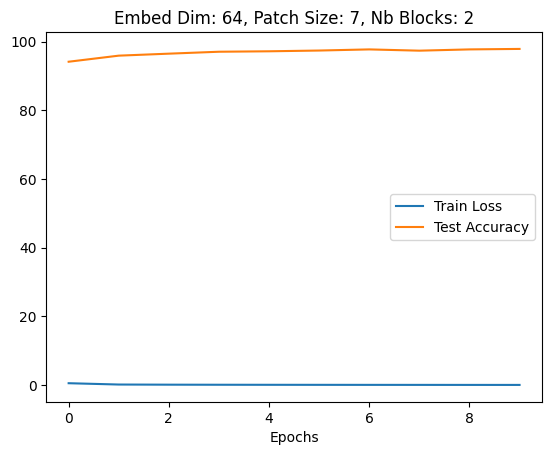

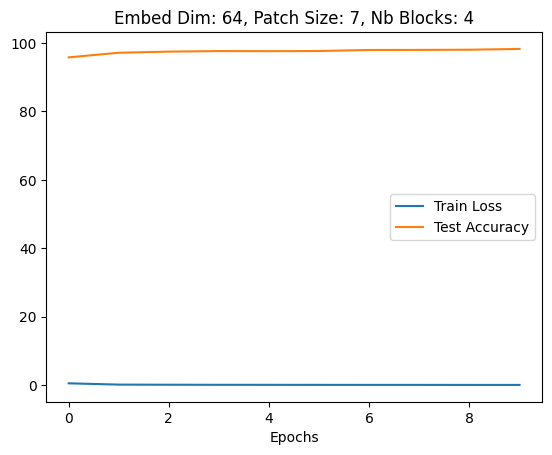

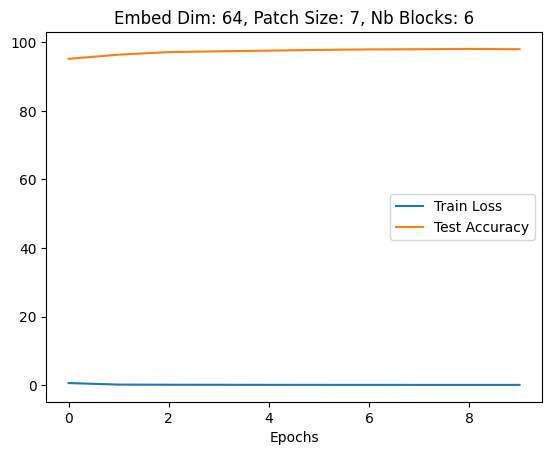

In [ ]:
# Define a range of hyperparameter values to test
nb_blocks_values = [2, 4, 6]

# Store results in a dictionary
results = {}

embed_dim = 64
patch_size = 7
for nb_blocks in nb_blocks_values:
        key = (embed_dim, patch_size, nb_blocks)
        train_losses, test_accuracies = train_and_evaluate(embed_dim, patch_size, nb_blocks)
        results[key] = (train_losses, test_accuracies)

# Plot and analyze the results
for key, (train_losses, test_accuracies) in results.items():
    embed_dim, patch_size, nb_blocks = key
    plt.figure()
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.title(f'Embed Dim: {embed_dim}, Patch Size: {patch_size}, Nb Blocks: {nb_blocks}')
    plt.legend()
    plt.show()

In [ ]:
# embed_dim = 64 accuracy, patch = 7, nb_blocks = 2
print(results[(64, 7, 2)][1][-1])

# embed_dim = 64 accuracy, patch = 7, nb_blocks = 4
print(results[(64, 7, 4)][1][-1])

# embed_dim = 64 accuracy, patch = 7, nb_blocks = 6
print(results[(64, 7, 6)][1][-1])

97.9
98.29
98.02


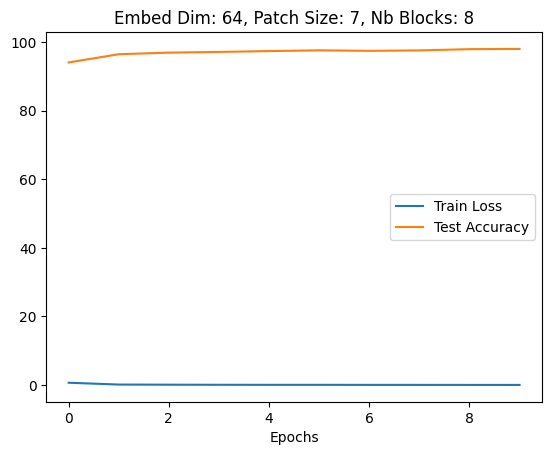

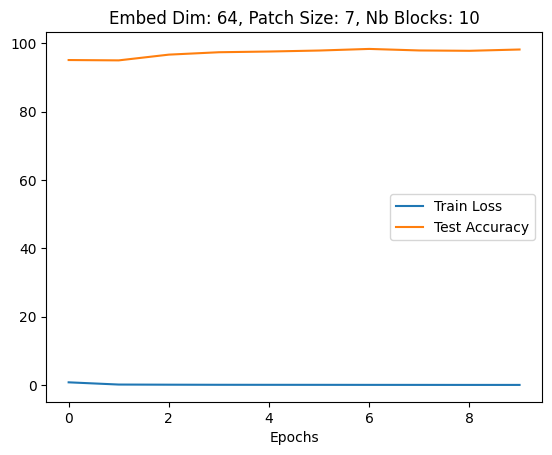

In [ ]:
# Define a range of hyperparameter values to test
nb_blocks_values = [8, 10]

# Store results in a dictionary
results = {}

embed_dim = 64
patch_size = 7
for nb_blocks in nb_blocks_values:
        key = (embed_dim, patch_size, nb_blocks)
        train_losses, test_accuracies = train_and_evaluate(embed_dim, patch_size, nb_blocks)
        results[key] = (train_losses, test_accuracies)

# Plot and analyze the results
for key, (train_losses, test_accuracies) in results.items():
    embed_dim, patch_size, nb_blocks = key
    plt.figure()
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.title(f'Embed Dim: {embed_dim}, Patch Size: {patch_size}, Nb Blocks: {nb_blocks}')
    plt.legend()
    plt.show()

In [ ]:
# embed_dim = 64 accuracy, patch = 7, nb_blocks = 8
print(results[(64, 7, 8)][1][-1])

# embed_dim = 64 accuracy, patch = 7, nb_blocks = 10
print(results[(64, 7, 10)][1][-1])

98.04
98.16


# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [ ]:
!pip install timm

a) Load the model using the timm library without pretrained wewights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [ ]:
import timm
model = timm.create_model('vit_base_patch8_224', pretrained=False)

In [ ]:
timm.list_models("*vit*")

['convit_base',
 'convit_small',
 'convit_tiny',
 'crossvit_9_240',
 'crossvit_9_dagger_240',
 'crossvit_15_240',
 'crossvit_15_dagger_240',
 'crossvit_15_dagger_408',
 'crossvit_18_240',
 'crossvit_18_dagger_240',
 'crossvit_18_dagger_408',
 'crossvit_base_240',
 'crossvit_small_240',
 'crossvit_tiny_240',
 'davit_base',
 'davit_giant',
 'davit_huge',
 'davit_large',
 'davit_small',
 'davit_tiny',
 'efficientvit_b0',
 'efficientvit_b1',
 'efficientvit_b2',
 'efficientvit_b3',
 'efficientvit_m0',
 'efficientvit_m1',
 'efficientvit_m2',
 'efficientvit_m3',
 'efficientvit_m4',
 'efficientvit_m5',
 'fastvit_ma36',
 'fastvit_s12',
 'fastvit_sa12',
 'fastvit_sa24',
 'fastvit_sa36',
 'fastvit_t8',
 'fastvit_t12',
 'flexivit_base',
 'flexivit_large',
 'flexivit_small',
 'gcvit_base',
 'gcvit_small',
 'gcvit_tiny',
 'gcvit_xtiny',
 'gcvit_xxtiny',
 'levit_128',
 'levit_128s',
 'levit_192',
 'levit_256',
 'levit_256d',
 'levit_384',
 'levit_384_s8',
 'levit_512',
 'levit_512_s8',
 'levit_512d',

In [ ]:
x = torch.randn(32, 1, 28, 28)
x = x.repeat(1, 3, 1, 1)  # Repeat the channel 3 times
# x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
model(x).shape

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [ ]:
model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=10, img_size=28, in_chans=3)
model(torch.randn(32, 3, 28, 28)).shape

torch.Size([32, 10])

c) redo the training with the pretrained ViT-S





In [ ]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
import timm

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 0.8156649504007816
--- Epoch 1 ---
Train loss: 0.5541993769755496
--- Epoch 2 ---
Train loss: 0.4825832723681606
--- Epoch 3 ---
Train loss: 0.4462434428968409
--- Epoch 4 ---
Train loss: 0.42264499097490615
--- Epoch 5 ---
Train loss: 0.4167078952354663
--- Epoch 6 ---
Train loss: 0.394757931770038
--- Epoch 7 ---
Train loss: 0.3851229101101727
--- Epoch 8 ---
Train loss: 0.3770584543185956
--- Epoch 9 ---
Train loss: 0.3683895971348037
Test accuracy: 87.27


--- Epoch 0 ---
Train loss: 0.8754552094412765
Test accuracy: 81.09
--- Epoch 1 ---
Train loss: 0.5755076486545839
Test accuracy: 82.6
--- Epoch 2 ---
Train loss: 0.5175102489716463
Test accuracy: 83.42
--- Epoch 3 ---
Train loss: 0.47139155140309447
Test accuracy: 86.55
--- Epoch 4 ---
Train loss: 0.4420367548587734
Test accuracy: 86.65
--- Epoch 5 ---
Train loss: 0.4193758386284558
Test accuracy: 86.81
--- Epoch 6 ---
Train loss: 0.3974786673082726
Test accuracy: 87.46
--- Epoch 7 ---
Train loss: 0.3818826459046366
Test accuracy: 87.62
--- Epoch 8 ---
Train loss: 0.3868681646105069
Test accuracy: 87.58
--- Epoch 9 ---
Train loss: 0.3523428958298555
Test accuracy: 87.66


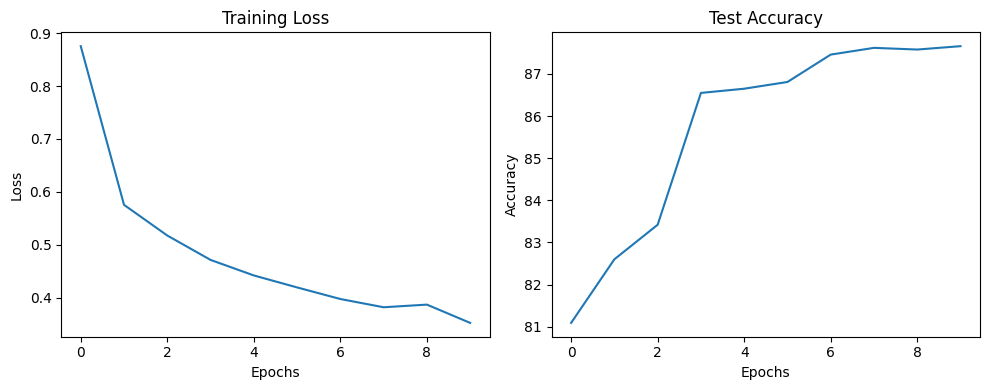

In [ ]:
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# Define the model, optimizer, and other parameters
# model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.cuda()
model.train()

epochs = 10
opt = torch.optim.Adam(model.parameters())

# Lists to store training loss and test accuracy
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        opt.zero_grad()
        x = x.repeat(1, 3, 1, 1)  # adapt number of channels to fit in ViT
        yhat = model(x)
        loss = F.cross_entropy(yhat, y)
        loss.backward()

        opt.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {train_loss / len(train_loader)}")

    # Evaluate the model on the test dataset and calculate accuracy
    test_accuracy = eval_model(model, test_loader, num_channels=3)
    test_accuracies.append(test_accuracy)
    print(f"Test accuracy: {test_accuracy}")

# Plot training loss and test accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.plot(range(epochs), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")

plt.tight_layout()
plt.show()

c) redo the training but with the ViT-S pretrained on ImageNet

In [ ]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=10, img_size=28, in_chans=3)

In [ ]:
import timm


# Move the model to GPU
model = model.cuda()

model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 0.515058062446397
--- Epoch 1 ---
Train loss: 0.33469689238681466
--- Epoch 2 ---
Train loss: 0.29064492986146323
--- Epoch 3 ---
Train loss: 0.26186470711218524
--- Epoch 4 ---
Train loss: 0.24527471839809722
--- Epoch 5 ---
Train loss: 0.23594902198451922
--- Epoch 6 ---
Train loss: 0.2178411196385111
--- Epoch 7 ---
Train loss: 0.20416449452005725
--- Epoch 8 ---
Train loss: 0.19858958842212965
--- Epoch 9 ---
Train loss: 0.20096802686069057
Test accuracy: 91.32


--- Epoch 0 ---
Train loss: 0.5322634352803993
Test accuracy: 86.92
--- Epoch 1 ---
Train loss: 0.32651332964393887
Test accuracy: 90.03
--- Epoch 2 ---
Train loss: 0.29025494628178794
Test accuracy: 89.97
--- Epoch 3 ---
Train loss: 0.2564916276156521
Test accuracy: 90.95
--- Epoch 4 ---
Train loss: 0.2396717150010534
Test accuracy: 91.51
--- Epoch 5 ---
Train loss: 0.22031222638100195
Test accuracy: 91.03
--- Epoch 6 ---
Train loss: 0.20701863327577932
Test accuracy: 91.34
--- Epoch 7 ---
Train loss: 0.193402159982907
Test accuracy: 91.38
--- Epoch 8 ---
Train loss: 0.17650026225173143
Test accuracy: 91.38
--- Epoch 9 ---
Train loss: 0.16819700795704368
Test accuracy: 91.64


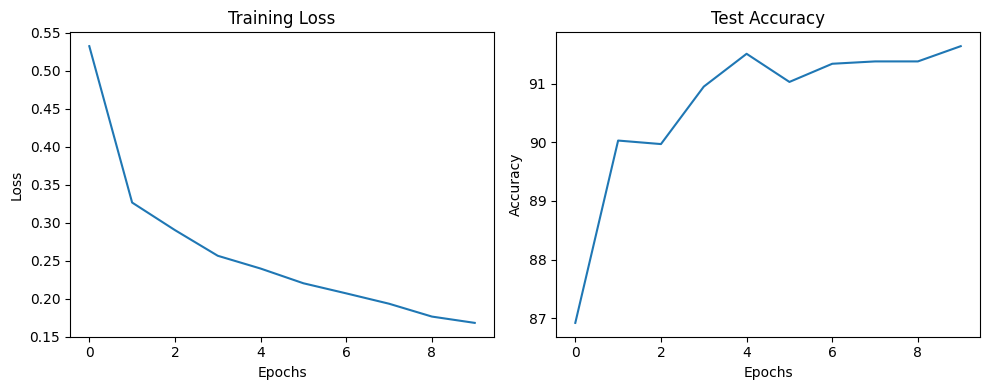

In [ ]:
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# Define the model, optimizer, and other parameters
# model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.cuda()
model.train()

epochs = 10
opt = torch.optim.Adam(model.parameters())

# Lists to store training loss and test accuracy
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        opt.zero_grad()
        x = x.repeat(1, 3, 1, 1)  # adapt number of channels to fit in ViT
        yhat = model(x)
        loss = F.cross_entropy(yhat, y)
        loss.backward()

        opt.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {train_loss / len(train_loader)}")

    # Evaluate the model on the test dataset and calculate accuracy
    test_accuracy = eval_model(model, test_loader, num_channels=3)
    test_accuracies.append(test_accuracy)
    print(f"Test accuracy: {test_accuracy}")

# Plot training loss and test accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.plot(range(epochs), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")

plt.tight_layout()
plt.show()

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.